# Parkinson Disease Dataset

### Matrix Column Entries ( Attributes ):			

**name** - ASCII subject name and recording number					
**MDVP:Fo(Hz)** - Average vocal fundamental frequency					
**MDVP:Fhi(Hz)** - Maximum vocal fundamental frequency					
**MDVP:Flo(Hz)** - Minimum vocal fundamental frequency					

**MDVP:Jitter(%) MDVP:Jitter(Abs)	MDVP:RAP	MDVP:PPQ	Jitter:DDP** - Several measures of variation in fundamental frequency					

**MDVP:Shimmer, MDVP:Shimmer(dB), 
Shimmer:APQ, Shimmer:APQ5, MDVP:APQ, Shimmer:DDA** - Several measures of variation in amplitude

**NHR	HNR** - Two measures of ratio of noise to tonal components in the voice				
**status** - Health status of the subject (one) - Parkinson's	 (zero) - healthy				
**RPDE	D2** - Two nonlinear dynamical complexity measures				
**DFA** - Signal fractal scaling exponent					
**spread1	spread2	PPE** - Three nonlinear measures of fundamental frequency variation 			

In [1]:
import pandas as pd, numpy as np,  warnings
warnings.simplefilter("ignore")
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import lime
from lime import lime_tabular

df = pd.read_csv('parkinsons.csv')

In [2]:
df.status.unique()  # Status 0 - Healthy Status 1 - PD

array([1, 0], dtype=int64)

In [3]:
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


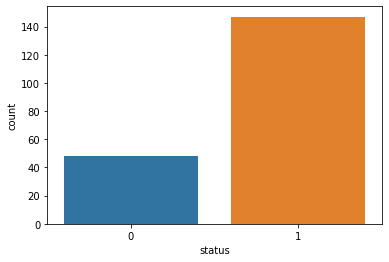

In [4]:
sns.countplot(x='status',data=df)

In [5]:
# More observations are there for Class 1 - PD

In [6]:
df.set_index('name', inplace=True) 

Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE'],
      dtype='object')


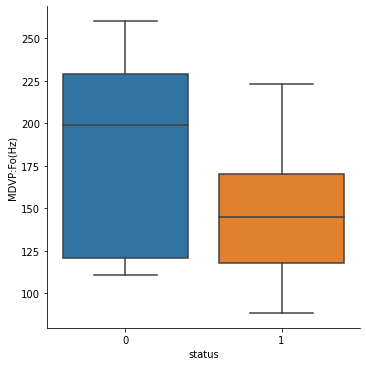

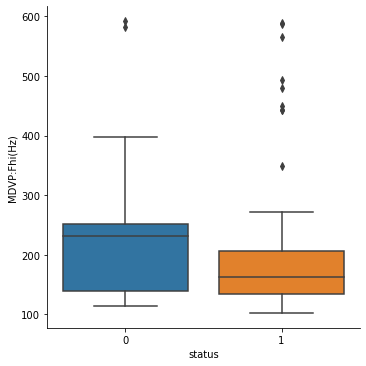

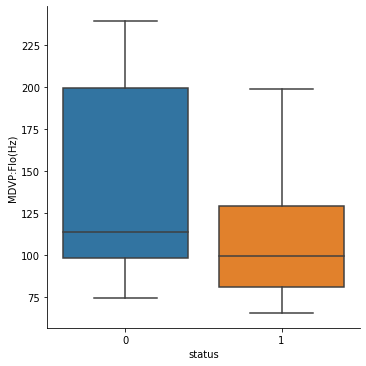

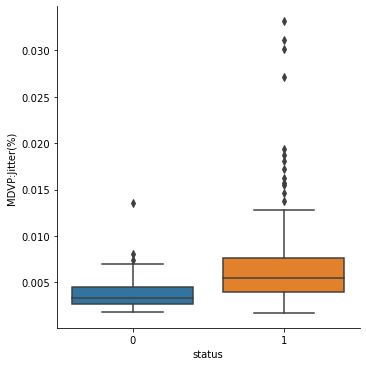

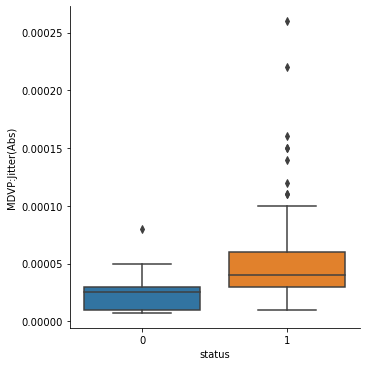

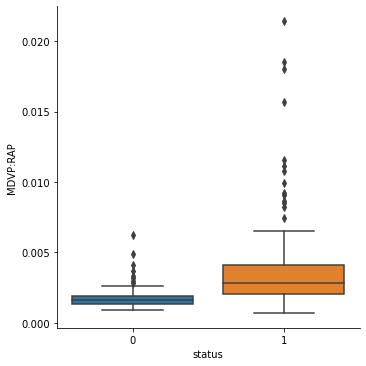

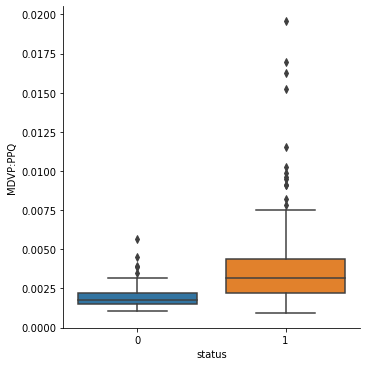

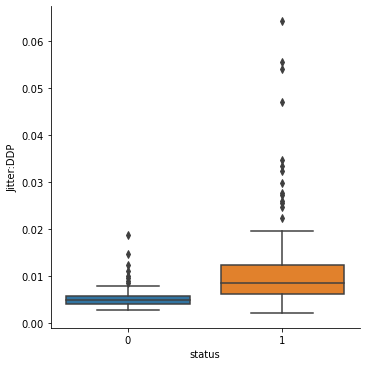

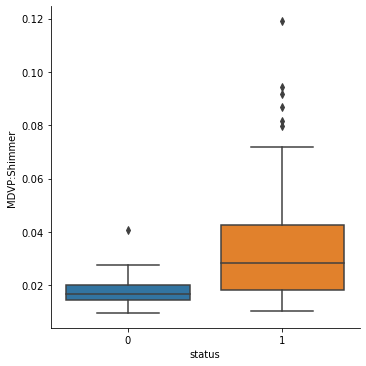

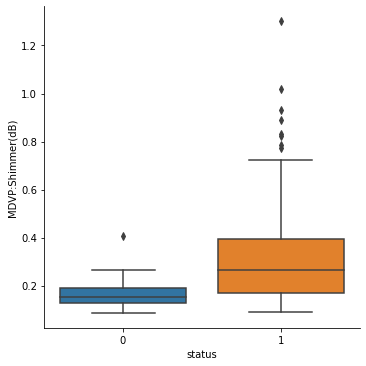

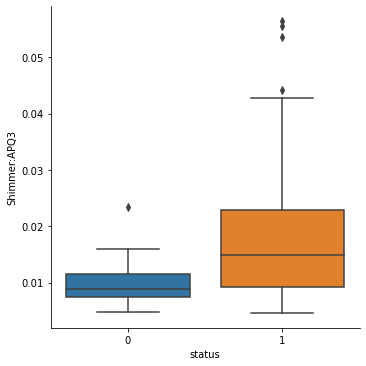

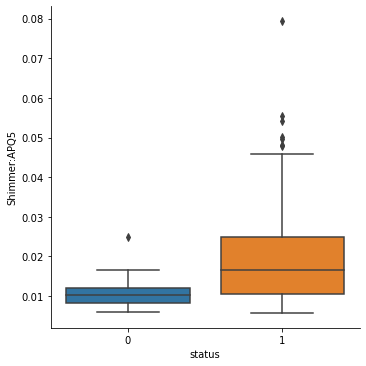

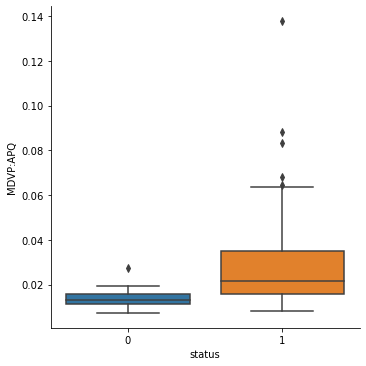

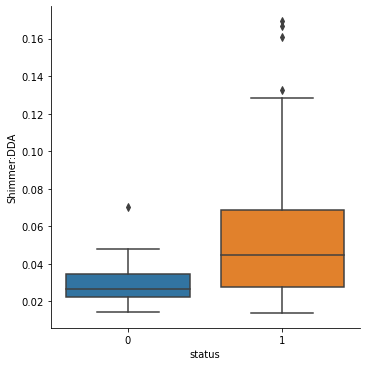

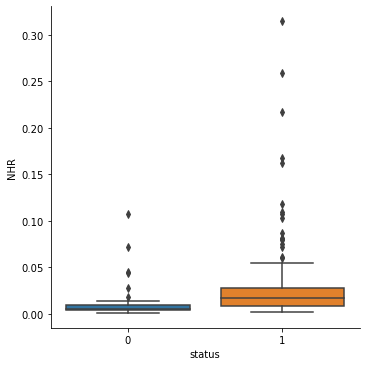

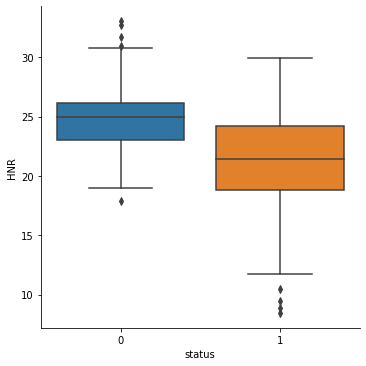

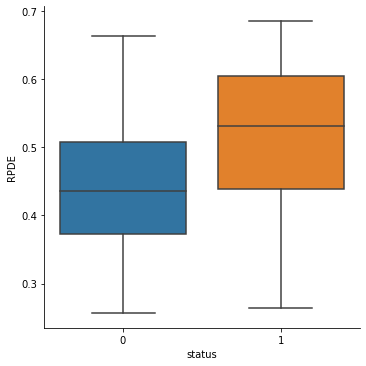

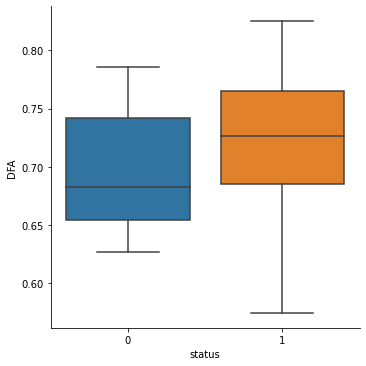

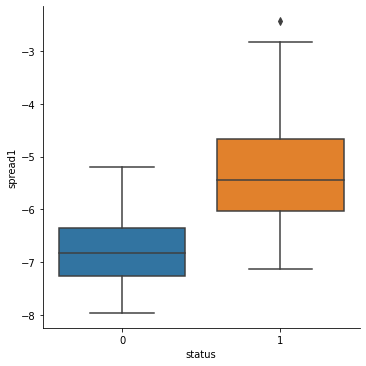

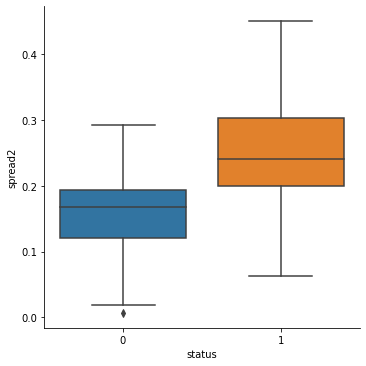

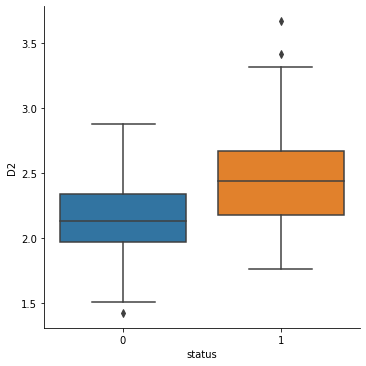

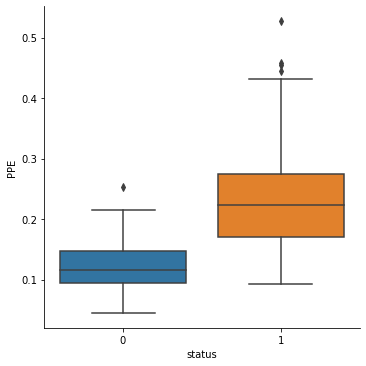

In [7]:
num_df = df.drop('status', 1).select_dtypes(include='number')
print(num_df.columns)
for col in num_df.columns:
    sns.catplot(y=col, x='status', kind='box', data=df)
    plt.show()

In [8]:
# Winsorization - Outlier Treatment
for i in num_df.columns:
    q1= df[i].quantile(0.25)
    q3= df[i].quantile(0.75)
    iqr = q3-q1
    
    ub = q3 + 1.5*iqr
    lb  = q1 - 1.5*iqr

    df[i] = df[i].replace(dict.fromkeys(df[df[i]>ub][i], df[i].quantile(0.99))) 
    df[i] = df[i].replace(dict.fromkeys(df[df[i]< lb][i],df[i].quantile(0.01)))

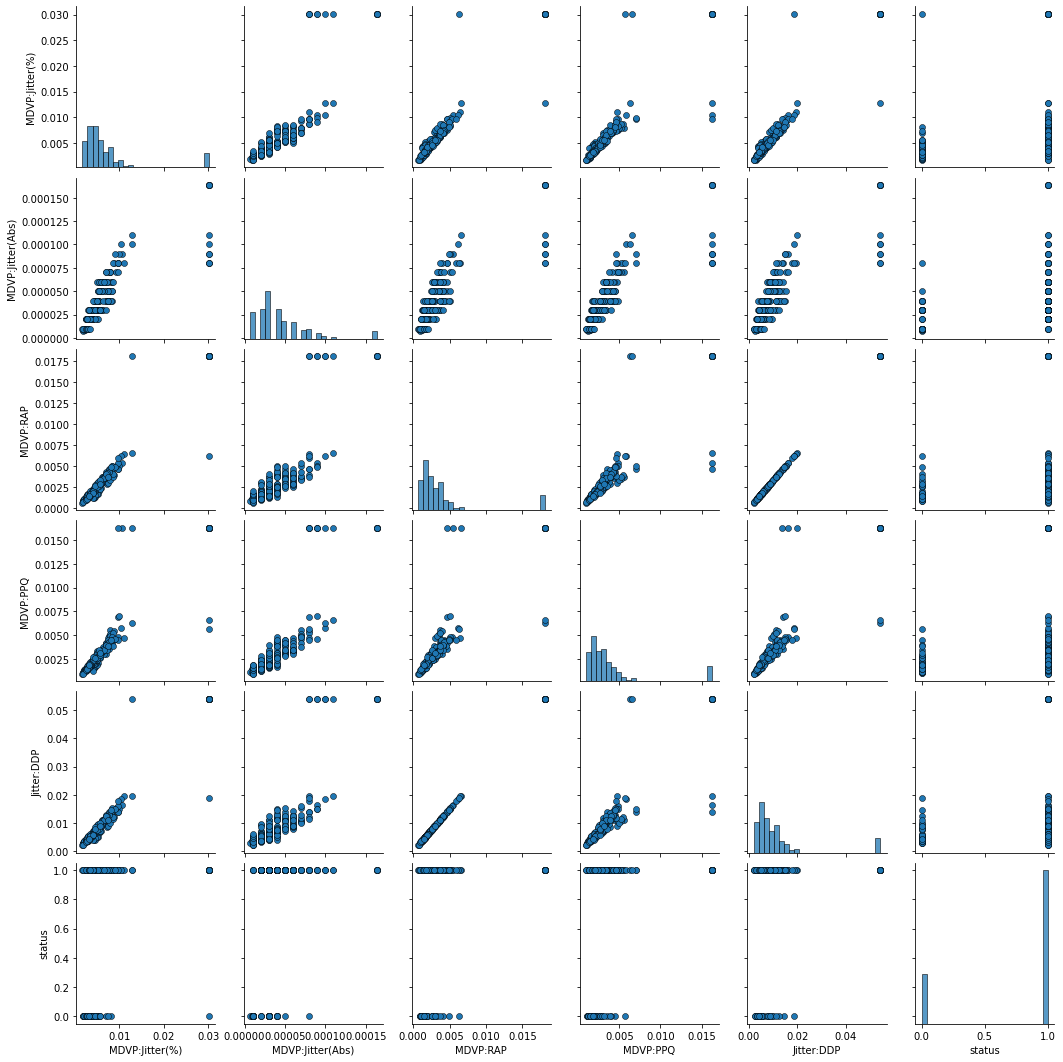

In [9]:
freq_measure = ['MDVP:Jitter(%)' , 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'status']
sns.pairplot(df[freq_measure], diag_kws={'edgecolor':'k','bins':25},plot_kws={'edgecolor':'k'})

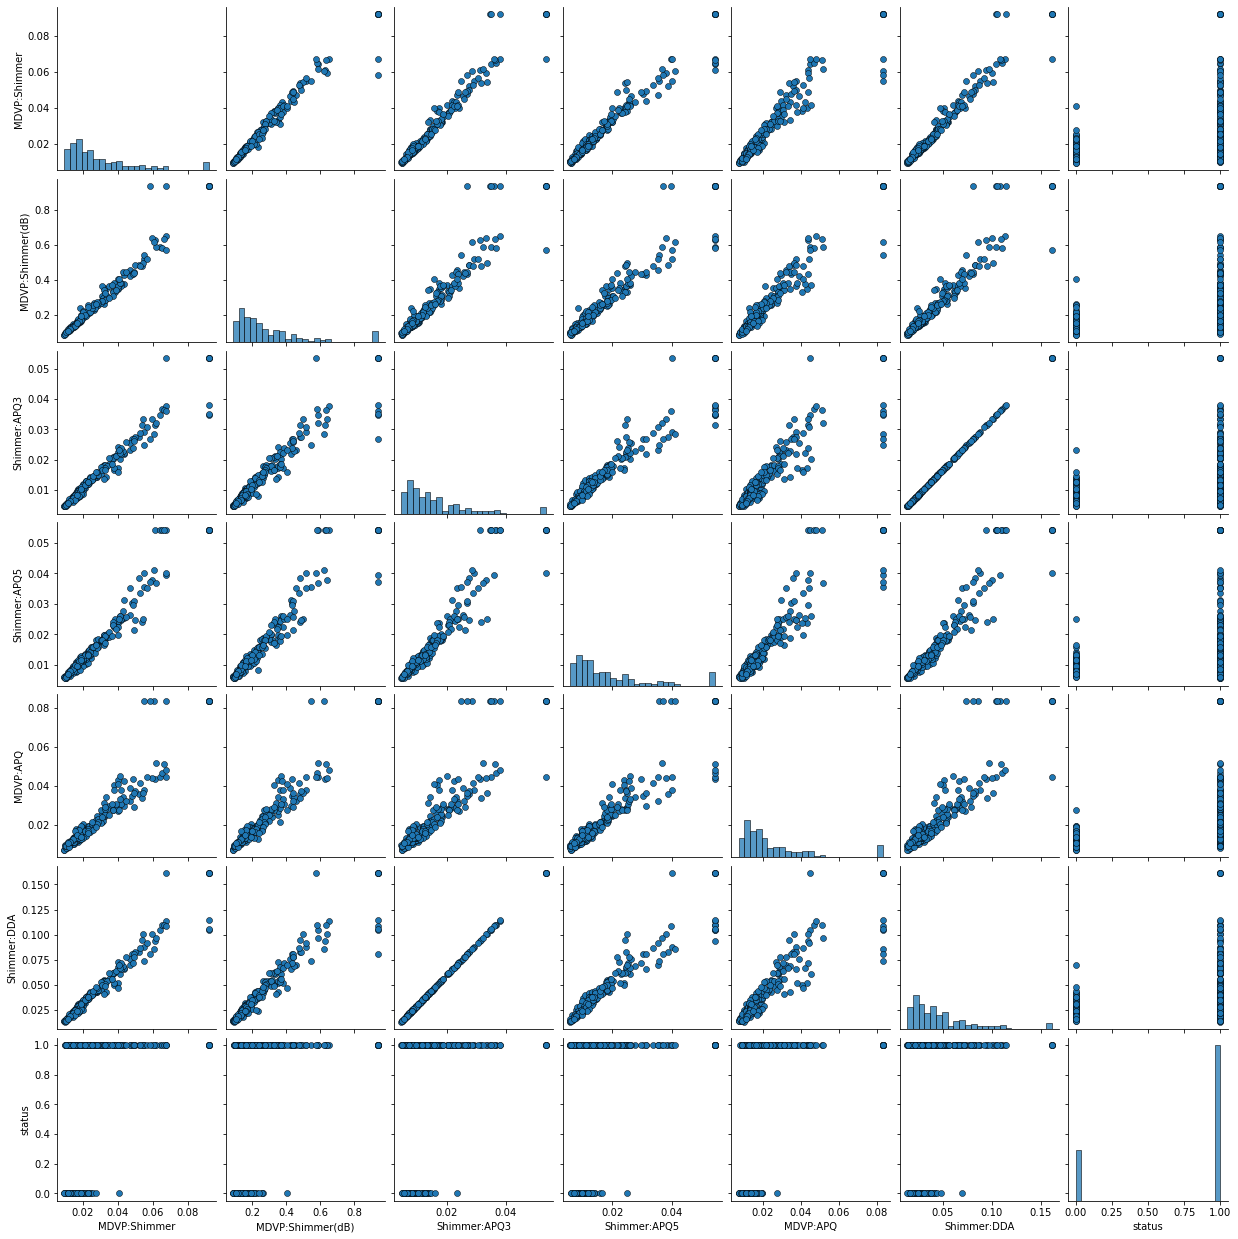

In [10]:
amp_measure = ['MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA','status']
sns.pairplot(df[amp_measure], diag_kws={'edgecolor':'k','bins':25},plot_kws={'edgecolor':'k'})

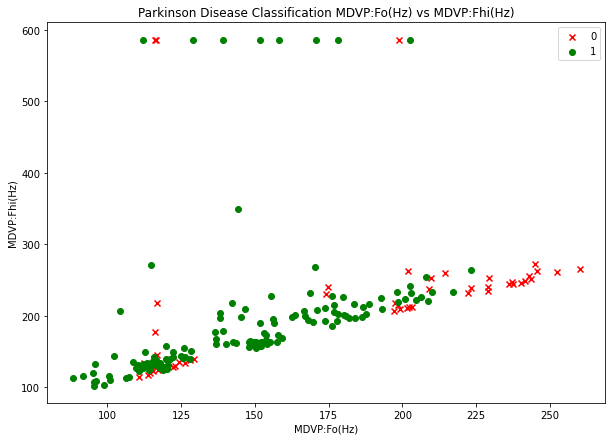

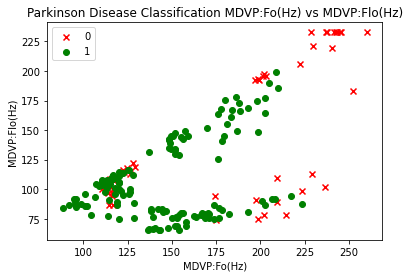

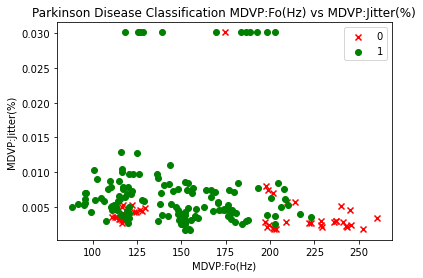

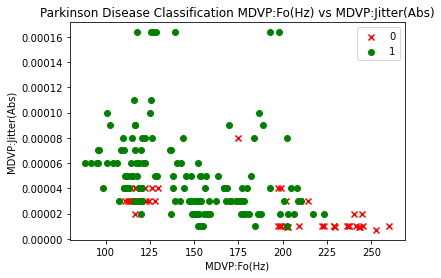

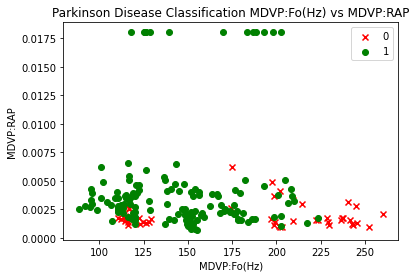

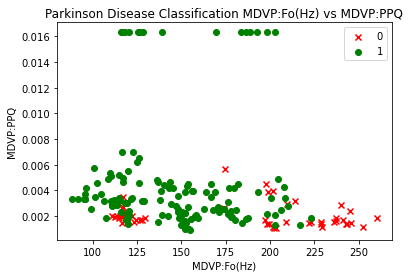

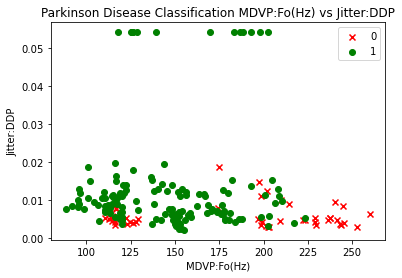

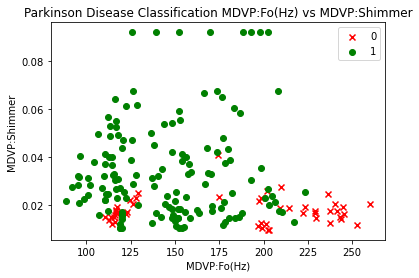

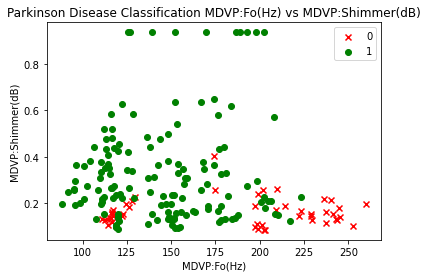

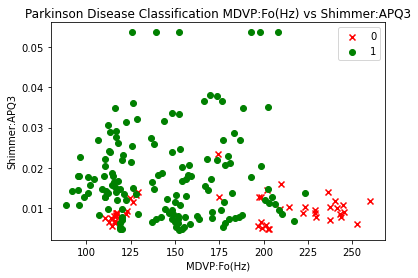

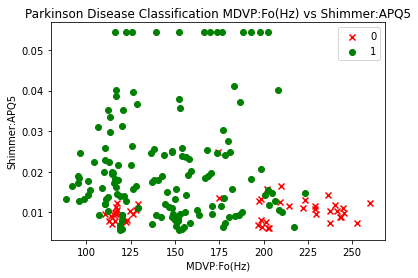

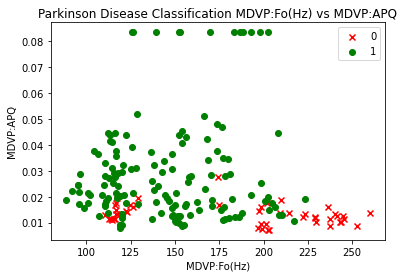

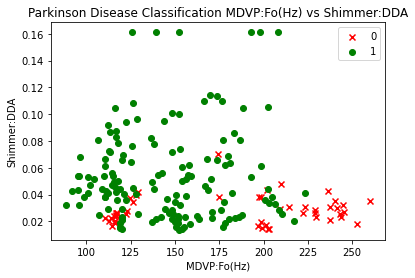

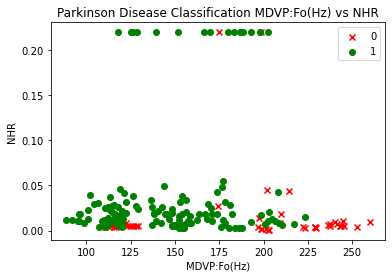

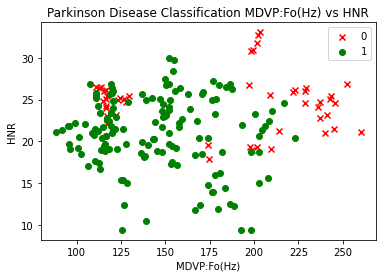

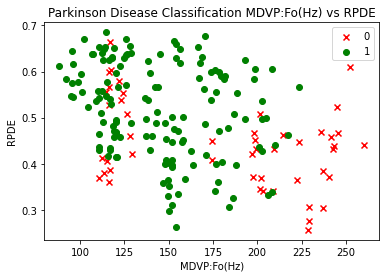

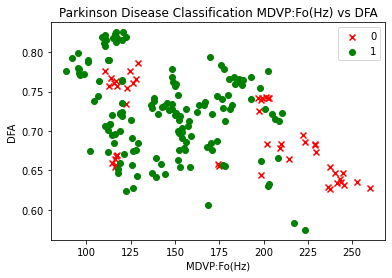

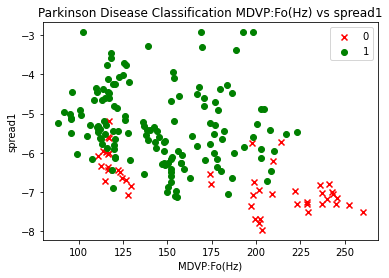

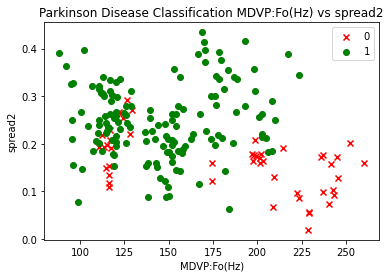

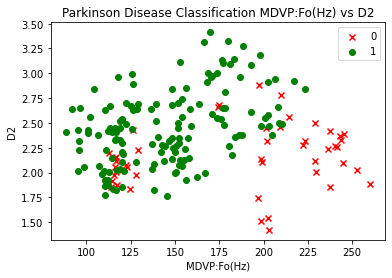

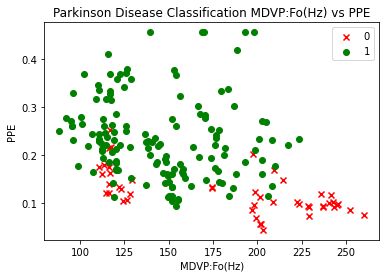

In [11]:
# Bivariate Analysis with respect to target column Status
cols  =  ['MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE']

markers = { 1: {'marker': 'o', 'facecolor': 'g', 'edgecolor': 'g'}, 
           0: {'marker': 'x', 'facecolor': 'r', 'edgecolor': 'r'}, 
          } 
plt.figure(figsize=(10, 7)) 

for col in cols:
    for name, group in df.groupby('status'): 
        plt.scatter(group['MDVP:Fo(Hz)'], group[col],
                            label=name, marker=markers[name]['marker'], 
                            facecolors=markers[name]['facecolor'], 
                            edgecolor=markers[name]['edgecolor']) 
    
    plt.title(f'Parkinson Disease Classification MDVP:Fo(Hz) vs {col}'); 
    plt.xlabel('MDVP:Fo(Hz)') 
    plt.ylabel(f'{col}')
    plt.legend()
    plt.show()

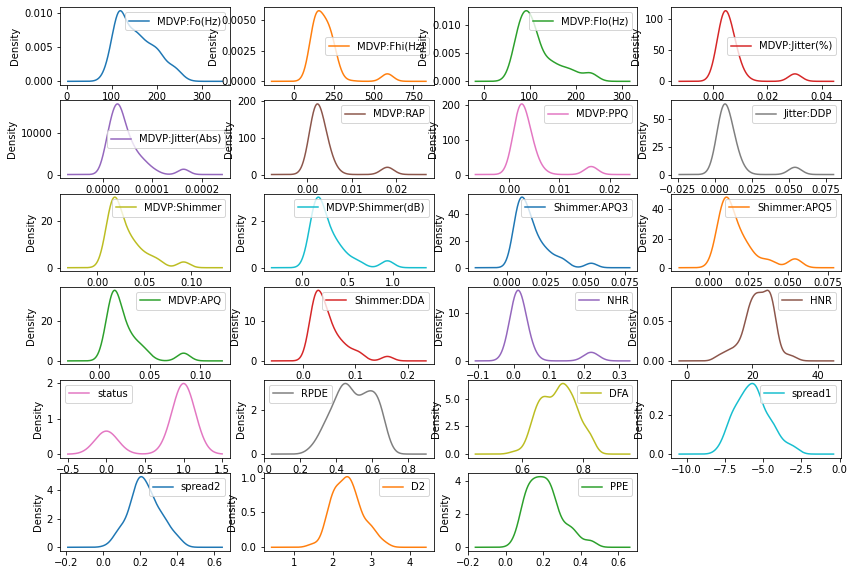

In [12]:
# Distribution
df.plot(subplots=True, kind='kde', sharex=False, sharey=False,  layout=(6, 4), figsize=(14,10))
plt.show()

In [13]:
stats_df = pd.DataFrame()

stats_df['Feature'] = df.columns
stats_df['Skew'] = df.skew().reset_index()[0]
stats_df['Kurtosis'] = df.kurtosis().reset_index()[0]
stats_df

,Feature,Skew,Kurtosis
0,MDVP:Fo(Hz),0.591737,-0.627898
1,MDVP:Fhi(Hz),2.702406,7.540070
2,MDVP:Flo(Hz),1.229625,0.694033
3,MDVP:Jitter(%),2.783634,6.903019
4,MDVP:Jitter(Abs),1.919567,4.465245
5,MDVP:RAP,2.857606,7.211161
6,MDVP:PPQ,2.664336,6.153317
7,Jitter:DDP,2.858012,7.212875
8,MDVP:Shimmer,1.610761,2.410891
9,MDVP:Shimmer(dB),1.852928,3.325328


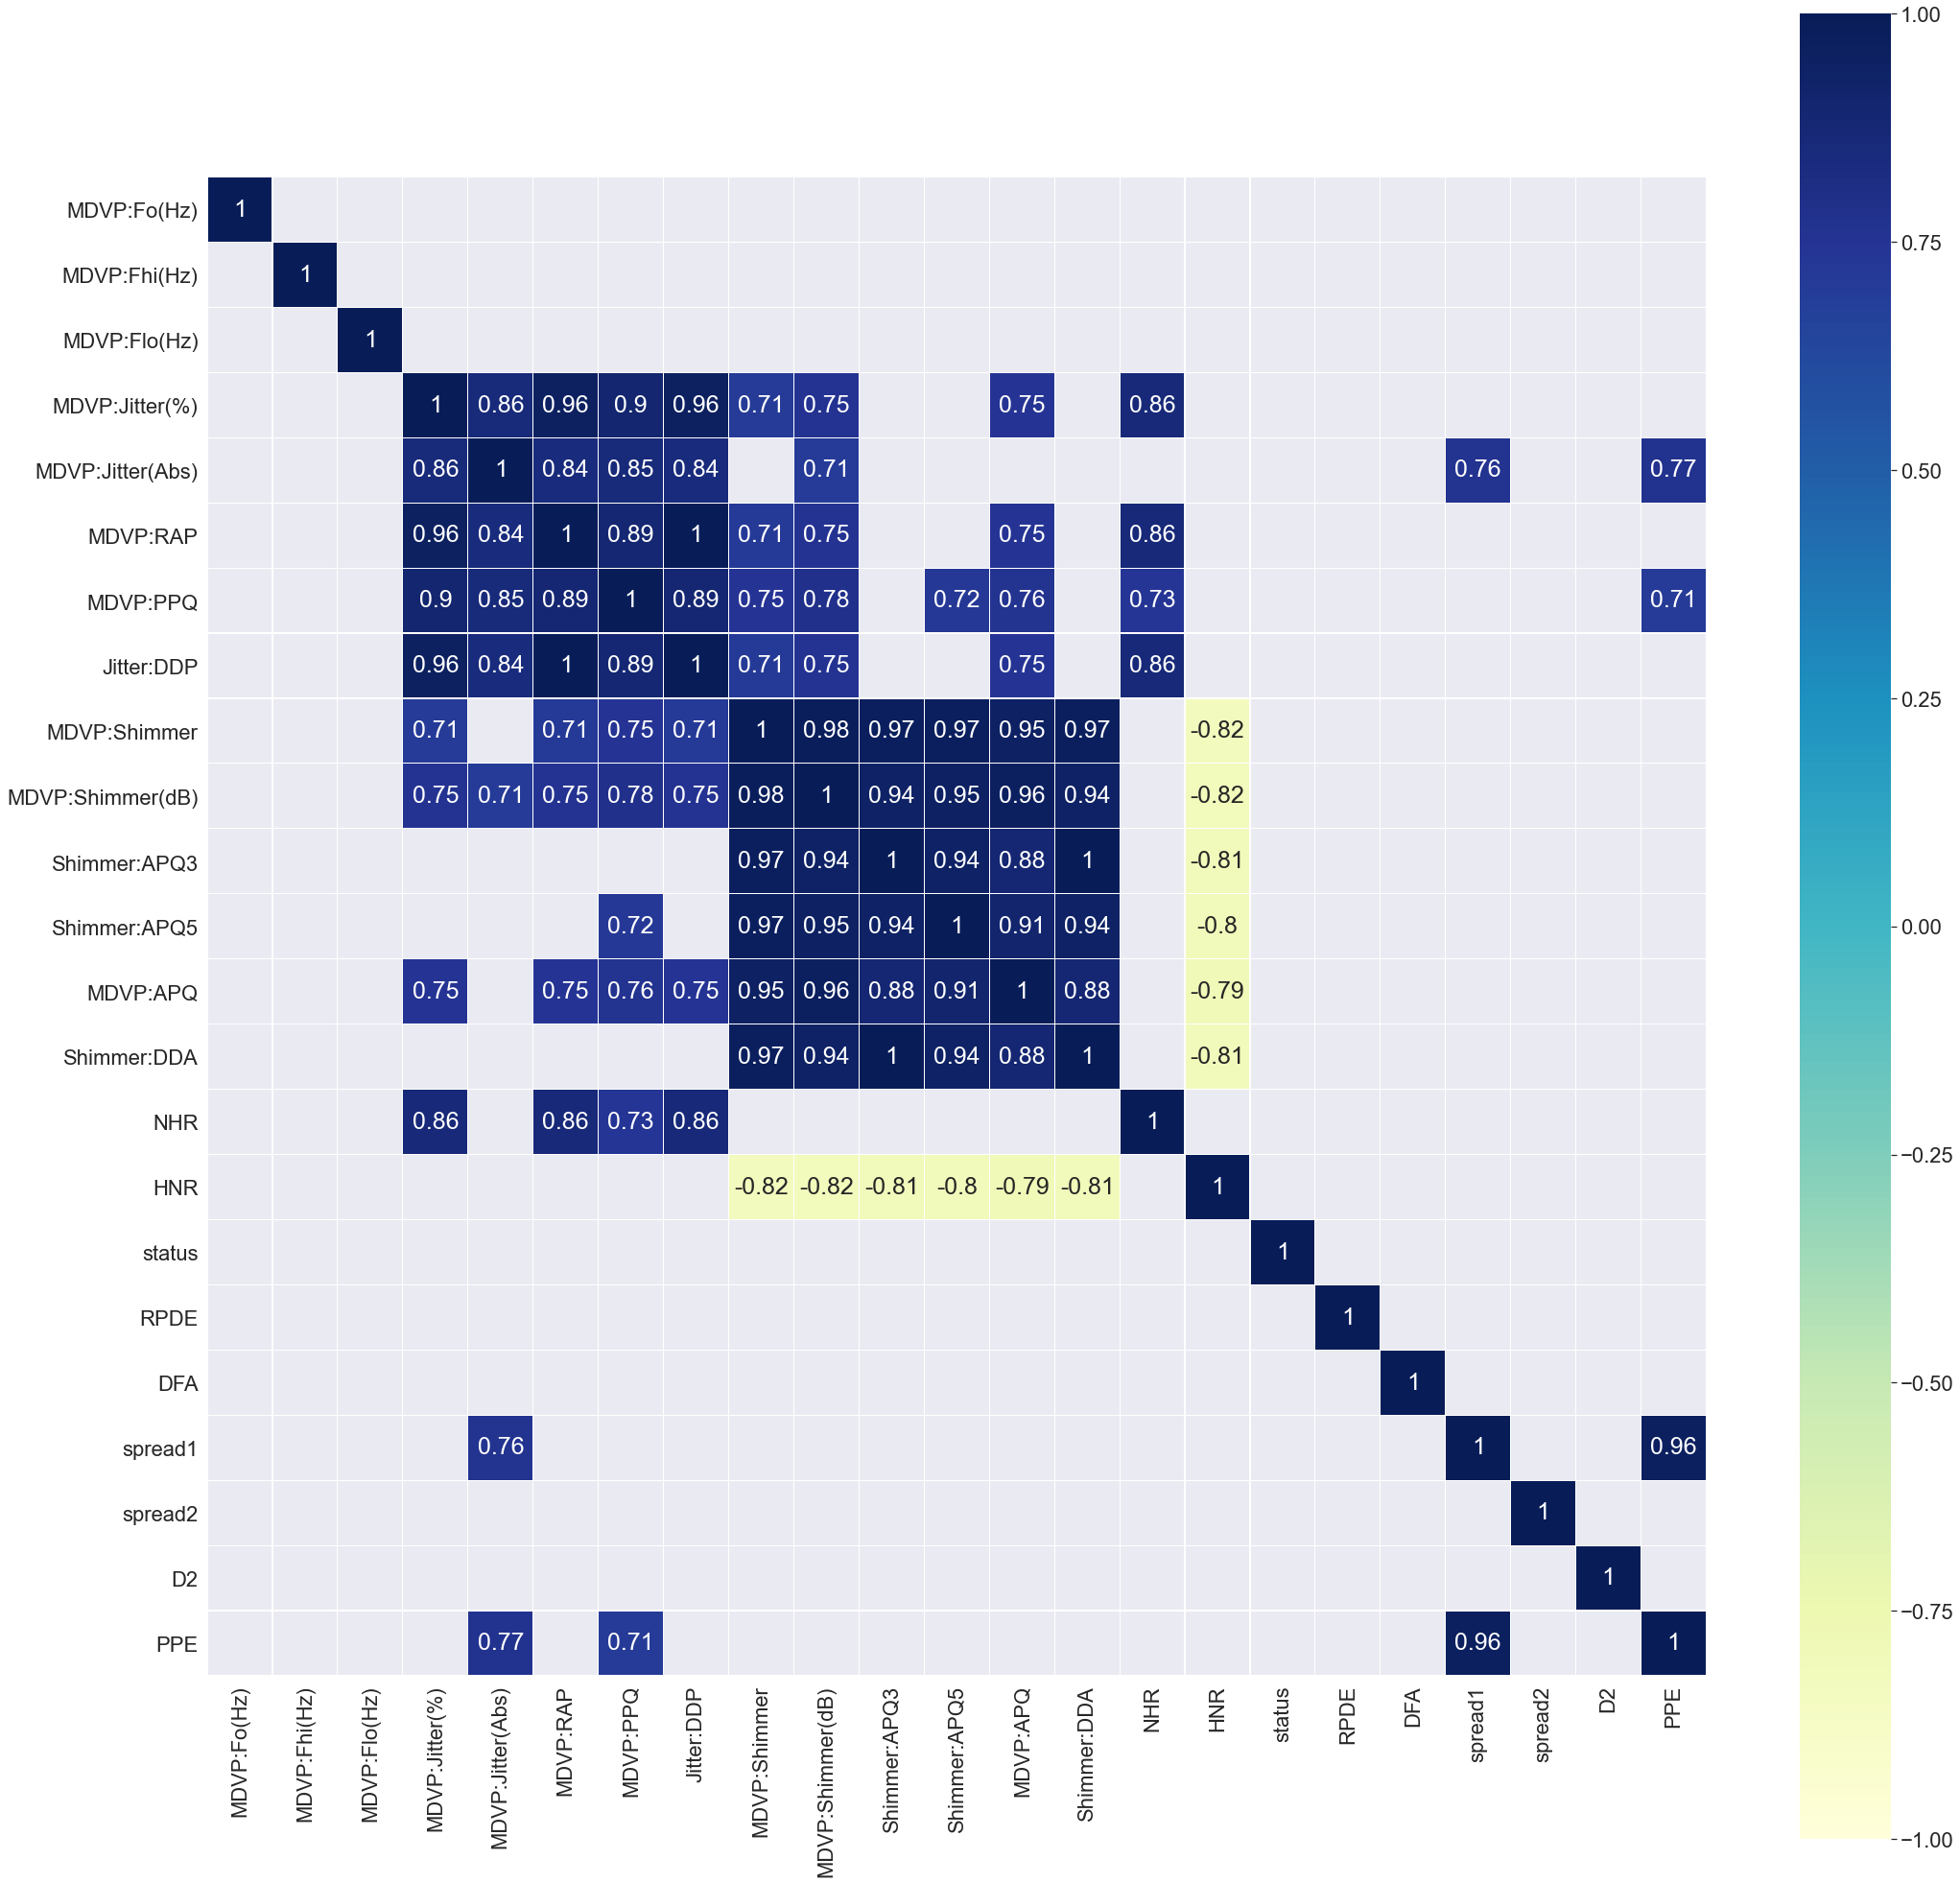

In [14]:
corr = df.corr()
sns.set(font_scale=2)
plt.figure(figsize=(35, 35))
sns.heatmap(corr[((corr >= 0.7) | (corr <= -0.7)) ], vmax=1.0, vmin=-1.0, linewidths=0.1,
           cmap='YlGnBu', annot=True, annot_kws={"size": 25}, square=True);

In [15]:
df.columns

Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

In [16]:
# Transformation

scaler = StandardScaler()

scaler.fit(df.drop('status',axis=1))
scaled_features = scaler.transform(df.drop('status',axis=1))

In [17]:
df_feat = pd.DataFrame(scaled_features,columns=df.drop('status', 1).columns)
df_feat.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,-0.829300,-0.419464,-0.949492,0.133590,0.808290,-0.009262,0.446352,-0.010175,0.719452,0.701111,...,0.269838,0.567251,-0.196451,-0.195941,-0.807838,1.760814,0.809878,0.485646,-0.208730,0.878540
1,-0.770972,-0.501795,-0.059299,0.403108,1.115367,0.218791,0.819592,0.217842,1.635173,1.698672,...,1.036727,1.467672,-0.242015,-0.639465,-0.387524,1.837562,1.493391,1.326773,0.283649,1.821124
2,-0.909476,-0.668692,-0.111212,0.523220,1.422444,0.408435,3.280502,0.409056,1.166386,0.980428,...,0.609641,1.110717,-0.342190,-0.282915,-0.662075,1.942048,1.152498,1.029589,-0.100337,1.416807
3,-0.909622,-0.604365,-0.115546,0.445587,1.422444,0.307611,0.824849,0.306648,1.301143,1.155001,...,0.709550,1.268558,-0.335081,-0.284509,-0.613134,1.832380,1.454197,1.309210,0.067748,1.824501
4,-0.925657,-0.567159,-0.131849,0.865977,2.036598,0.674896,3.280502,0.675476,1.786579,1.489184,...,1.089976,1.803833,-0.268190,-0.511052,-0.783021,1.909364,1.796690,0.096545,-0.127103,2.288501


In [18]:
df_feat['name'] = df.index
df_feat.set_index('name', inplace=True)

df_feat.head(3)

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
name,,,,,,,,,,,,,,,,,,,,,
phon_R01_S01_1,-0.829300,-0.419464,-0.949492,0.133590,0.808290,-0.009262,0.446352,-0.010175,0.719452,0.701111,...,0.269838,0.567251,-0.196451,-0.195941,-0.807838,1.760814,0.809878,0.485646,-0.208730,0.878540
phon_R01_S01_2,-0.770972,-0.501795,-0.059299,0.403108,1.115367,0.218791,0.819592,0.217842,1.635173,1.698672,...,1.036727,1.467672,-0.242015,-0.639465,-0.387524,1.837562,1.493391,1.326773,0.283649,1.821124
phon_R01_S01_3,-0.909476,-0.668692,-0.111212,0.523220,1.422444,0.408435,3.280502,0.409056,1.166386,0.980428,...,0.609641,1.110717,-0.342190,-0.282915,-0.662075,1.942048,1.152498,1.029589,-0.100337,1.416807


In [19]:
# Train-test Split
X_train, X_test, y_train, y_test = train_test_split(df_feat,df['status'],  test_size=0.3, random_state=123)

In [20]:
knn = KNeighborsClassifier(n_neighbors=3, p=2, metric='minkowski')
knn.fit(X_train,y_train)

print ("\nK-Nearest Neighbors - Train Confusion Matrix\n\n",pd.crosstab(y_train,knn.predict(X_train),rownames = ["Actuall"],colnames = ["Predicted"]) )     
print ("\nK-Nearest Neighbors - Train accuracy:",round(accuracy_score(y_train,knn.predict(X_train)),3))
print ("\nK-Nearest Neighbors - Train Classification Report\n",classification_report(y_train,knn.predict(X_train)))
print('\nMisclassification error rate', round(np.mean(knn.predict(X_train)!=y_train),3))


print ("\n\nK-Nearest Neighbors - Test Confusion Matrix\n\n",pd.crosstab(y_test,knn.predict(X_test),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nK-Nearest Neighbors - Test accuracy:",round(accuracy_score(y_test,knn.predict(X_test)),3))
print ("\nK-Nearest Neighbors - Test Classification Report\n",classification_report(y_test,knn.predict(X_test)))
print('\nMisclassification error rate', round(np.mean(knn.predict(X_test)!=y_test),3))


K-Nearest Neighbors - Train Confusion Matrix

 Predicted   0    1
Actuall           
0          30    2
1           1  103

K-Nearest Neighbors - Train accuracy: 0.978

K-Nearest Neighbors - Train Classification Report
               precision    recall  f1-score   support

           0       0.97      0.94      0.95        32
           1       0.98      0.99      0.99       104

    accuracy                           0.98       136
   macro avg       0.97      0.96      0.97       136
weighted avg       0.98      0.98      0.98       136


Misclassification error rate 0.022


K-Nearest Neighbors - Test Confusion Matrix

 Predicted   0   1
Actuall          
0          14   2
1           2  41

K-Nearest Neighbors - Test accuracy: 0.932

K-Nearest Neighbors - Test Classification Report
               precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.95      0.95      0.95        43

    accuracy                         

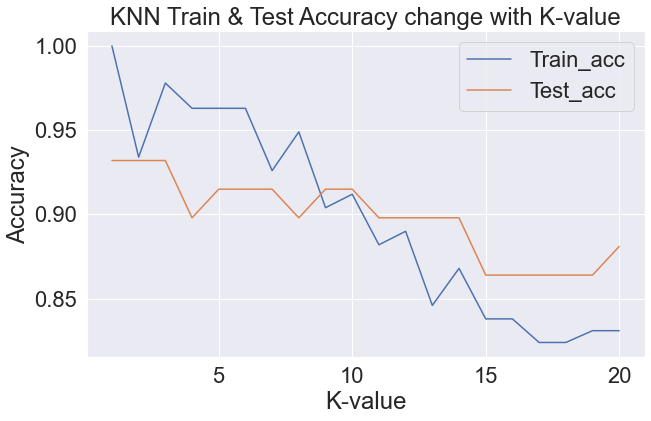

In [21]:
dummyarray = np.empty((20,5))
k_val_card = pd.DataFrame(dummyarray)
k_val_card.columns = ["K_value","Train_acc","Test_acc",'Train_Error_rate', 'Test_Error_rate']

k_vals = np.arange(1, 20+1)
for i in range(len(k_vals)):
    knn_fit = KNeighborsClassifier(n_neighbors=k_vals[i],p=2,metric='minkowski')
    knn_fit.fit(X_train,y_train)
    y_pred_train = knn_fit.predict(X_train)
    y_pred_test = knn_fit.predict(X_test)
#     print ("\nK-value",k_vals[i])
    
    tr_accscore = round(accuracy_score(y_train,y_pred_train),3)
    tr_error_rate = np.mean(y_train !=  y_pred_train)
#     print ("\nK-Nearest Neighbors - Train Confusion Matrix\n\n",pd.crosstab(y_train,y_pred_train,rownames=["Actual"],colnames=["Predicted"]) )     
#     print ("\nK-Nearest Neighbors - Train accuracy:",tr_accscore)
#     print ("\nK-Nearest Neighbors - Train Classification Report\n",classification_report(y_train,y_pred_train))
#     print('\nMisclassification error rate', tr_error_rate)
    
    ts_accscore = round(accuracy_score(y_test,y_pred_test),3) 
    ts_error_rate = np.mean(y_test != y_pred_test)
#     print ("\n\nK-Nearest Neighbors - Test Confusion Matrix\n\n",pd.crosstab(y_test,y_pred_test,rownames = ["Actual"],colnames = ["Predicted"]))      
#     print ("\nK-Nearest Neighbors - Test accuracy:",ts_accscore)
#     print ("\nK-Nearest Neighbors - Test Classification Report\n",classification_report(y_test,y_pred_test))
#     print('\nMisclassification error rate', ts_error_rate)
    
    k_val_card.loc[i, 'K_value'] = k_vals[i]      
    k_val_card.loc[i, 'Train_acc'] = tr_accscore     
    k_val_card.loc[i, 'Test_acc'] = ts_accscore
    k_val_card.loc[i, 'Train_Error_rate'] = tr_error_rate
    k_val_card.loc[i, 'Test_Error_rate'] = ts_error_rate


# Plotting accuracies over varied K-values
plt.figure(figsize=(10,6))
plt.title('KNN Train & Test Accuracy change with K-value')

plt.xlabel('K-value')
plt.ylabel('Accuracy')
plt.plot(k_val_card["K_value"],k_val_card["Train_acc"], label='Train_acc')
plt.plot(k_val_card["K_value"],k_val_card["Test_acc"], label='Test_acc')

plt.legend(loc='upper right')    
plt.show()

As per the above graph, we can clearly see that with less value of K-neighbour, it has more overfitting problems due to very high accuracy on train data and less on test data. 

With the increase in K-values more the train and test accuracies are converging and becoming more robust. 

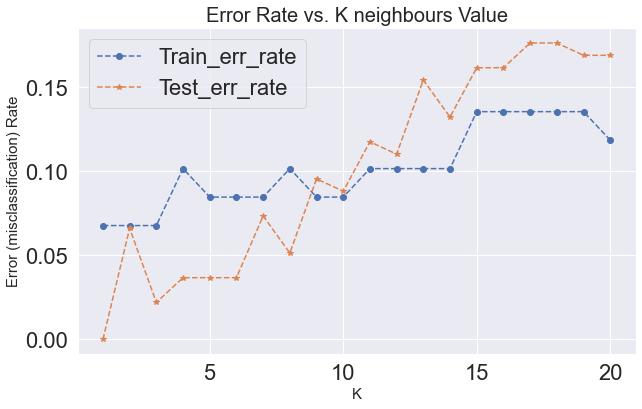

In [22]:
tr_error_rate = []
ts_error_rate = []

for i in range(1,21):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    y_pred_train = knn.predict(X_train)
    y_pred_test = knn.predict(X_test)
    tr_error_rate.append(np.mean(y_pred_train != y_train))
    ts_error_rate.append(np.mean(y_pred_test != y_test))
    

plt.figure(figsize=(10,6))
plt.plot(range(1,21),ts_error_rate, linestyle='dashed', marker='o', label='Train_err_rate')
plt.plot(range(1,21),tr_error_rate, linestyle='dashed', marker='*', label='Test_err_rate')
plt.title('Error Rate vs. K neighbours Value', fontsize=20)
plt.xlabel('K',fontsize=15)
plt.ylabel('Error (misclassification) Rate', fontsize=15)
plt.legend()
plt.show()

On the similar line of above interpretation, we can see overfitting problem exists in above error rate chart. 

# Decision Tree Classifier

In [23]:
# Train-test Split (df - not scaled)
X_train, X_test, y_train, y_test = train_test_split(df.drop('status',1),df['status'],  test_size=0.3, random_state=123)

In [24]:
dtree = DecisionTreeClassifier(criterion="gini",max_depth=5,min_samples_split=2,min_samples_leaf=1,random_state=123)
dtree.fit(X_train,y_train)

y_pred_train = dtree.predict(X_train)
y_pred_test = dtree.predict(X_test)

print ("\nDecision Tree - Train Confusion Matrix\n\n",pd.crosstab(y_train,y_pred_train,rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nDecision Tree - Train accuracy:",round(accuracy_score(y_train,y_pred_train),3))
print ("\nDecision Tree - Train Classification Report\n",classification_report(y_train,y_pred_train))
print('\nMisclassification error rate', round(np.mean(y_pred_train!=y_train),3))

print ("\n\nDecision Tree - Test Confusion Matrix\n\n",pd.crosstab(y_test,y_pred_test,rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nDecision Tree - Test accuracy:",round(accuracy_score(y_test,y_pred_test),3))
print ("\nDecision Tree - Test Classification Report\n",classification_report(y_test,y_pred_test))
print('\nMisclassification error rate', round(np.mean(y_pred_test!=y_test),3))


Decision Tree - Train Confusion Matrix

 Predicted   0    1
Actuall           
0          31    1
1           0  104

Decision Tree - Train accuracy: 0.993

Decision Tree - Train Classification Report
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        32
           1       0.99      1.00      1.00       104

    accuracy                           0.99       136
   macro avg       1.00      0.98      0.99       136
weighted avg       0.99      0.99      0.99       136


Misclassification error rate 0.007


Decision Tree - Test Confusion Matrix

 Predicted   0   1
Actuall          
0          12   4
1           6  37

Decision Tree - Test accuracy: 0.831

Decision Tree - Test Classification Report
               precision    recall  f1-score   support

           0       0.67      0.75      0.71        16
           1       0.90      0.86      0.88        43

    accuracy                           0.83        59
   macro avg       

In [25]:
dtree = DecisionTreeClassifier(criterion="entropy", max_depth=5,min_samples_split=2,min_samples_leaf=1,random_state=123)
dtree.fit(X_train,y_train)

y_pred_train = dtree.predict(X_train)
y_pred_test = dtree.predict(X_test)

print ("\nDecision Tree - Train Confusion Matrix\n\n",pd.crosstab(y_train,y_pred_train,rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nDecision Tree - Train accuracy:",round(accuracy_score(y_train,y_pred_train),3))
print ("\nDecision Tree - Train Classification Report\n",classification_report(y_train,y_pred_train))
print('\nMisclassification error rate', round(np.mean(y_pred_train!=y_train),3))

print ("\n\nDecision Tree - Test Confusion Matrix\n\n",pd.crosstab(y_test,y_pred_test,rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nDecision Tree - Test accuracy:",round(accuracy_score(y_test,y_pred_test),3))
print ("\nDecision Tree - Test Classification Report\n",classification_report(y_test,y_pred_test))
print('\nMisclassification error rate', round(np.mean(y_pred_test!=y_test),3))


Decision Tree - Train Confusion Matrix

 Predicted   0    1
Actuall           
0          32    0
1           0  104

Decision Tree - Train accuracy: 1.0

Decision Tree - Train Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00       104

    accuracy                           1.00       136
   macro avg       1.00      1.00      1.00       136
weighted avg       1.00      1.00      1.00       136


Misclassification error rate 0.0


Decision Tree - Test Confusion Matrix

 Predicted   0   1
Actuall          
0          15   1
1           7  36

Decision Tree - Test accuracy: 0.864

Decision Tree - Test Classification Report
               precision    recall  f1-score   support

           0       0.68      0.94      0.79        16
           1       0.97      0.84      0.90        43

    accuracy                           0.86        59
   macro avg       0.83

In [26]:
# In both (gini & entropy) criterion, we can infer that, the test accuracies are high (0.83, 0.86), but precision and recall
# for class 1 (PD) is low

# Train Accuracies for Class 1 
#            Precision    Recall
# Gini     -  0.99      1.00
# Entropy  -  1.00      1.00

# Test Accuracies for class 1
#            Precision    Recall
# Gini     - 0.90          0.86
# Entropy  - 0.97          0.84


# By using class weights, we can give importance to class 1 at a cost of an increase in other errors.

In [27]:
dummyarray = np.empty((6,10))
dt_wghts_tune = pd.DataFrame(dummyarray)

dt_wghts_tune.columns = ["zero_wght","one_wght","tr_accuracy","tst_accuracy","prec_zero","prec_one",
                     "prec_ovll","recl_zero","recl_one","recl_ovll"]

zero_class_wghts = [0.01,0.1,0.2,0.3,0.4,0.5]

for i in range(len(zero_class_wghts)):
    class_wght = {0:zero_class_wghts[i], 1:1.0-zero_class_wghts[i]}
    
    dt_fit = DecisionTreeClassifier(criterion="gini",max_depth=5,min_samples_split=2,
                                    min_samples_leaf=1,random_state=42,class_weight = class_wght)
    dt_fit.fit(X_train,y_train)
    
    dt_wghts_tune.loc[i, 'zero_wght'] = class_wght[0]       
    dt_wghts_tune.loc[i, 'one_wght'] = class_wght[1]     
    dt_wghts_tune.loc[i, 'tr_accuracy'] = round(accuracy_score(y_train,dt_fit.predict(X_train)),3)    
    dt_wghts_tune.loc[i, 'tst_accuracy'] = round(accuracy_score(y_test,dt_fit.predict(X_test)),3)    
        
    clf_spt = classification_report(y_test,dt_fit.predict(X_test)).split()
    dt_wghts_tune.loc[i, 'prec_zero'] = float(clf_spt[5])   
    dt_wghts_tune.loc[i, 'prec_one'] = float(clf_spt[10])   
    dt_wghts_tune.loc[i, 'prec_ovll'] = float(clf_spt[19])   
    
    dt_wghts_tune.loc[i, 'recl_zero'] = float(clf_spt[6])   
    dt_wghts_tune.loc[i, 'recl_one'] = float(clf_spt[11])   
    dt_wghts_tune.loc[i, 'recl_ovll'] = float(clf_spt[20])
    
    print ("\nClass Weights",class_wght,"Train accuracy:",round(accuracy_score(y_train,dt_fit.predict(X_train)),3),"Test accuracy:",round(accuracy_score(y_test,dt_fit.predict(X_test)),3))
    print ("Test Confusion Matrix\n\n",pd.crosstab(y_test,dt_fit.predict(X_test),rownames = ["Actual"],colnames = ["Predicted"]))      


Class Weights {0: 0.01, 1: 0.99} Train accuracy: 0.963 Test accuracy: 0.881
Test Confusion Matrix

 Predicted   0   1
Actual           
0          12   4
1           3  40

Class Weights {0: 0.1, 1: 0.9} Train accuracy: 0.963 Test accuracy: 0.881
Test Confusion Matrix

 Predicted   0   1
Actual           
0          12   4
1           3  40

Class Weights {0: 0.2, 1: 0.8} Train accuracy: 0.978 Test accuracy: 0.831
Test Confusion Matrix

 Predicted   0   1
Actual           
0          12   4
1           6  37

Class Weights {0: 0.3, 1: 0.7} Train accuracy: 0.978 Test accuracy: 0.864
Test Confusion Matrix

 Predicted   0   1
Actual           
0          12   4
1           4  39

Class Weights {0: 0.4, 1: 0.6} Train accuracy: 0.993 Test accuracy: 0.847
Test Confusion Matrix

 Predicted   0   1
Actual           
0          12   4
1           5  38

Class Weights {0: 0.5, 1: 0.5} Train accuracy: 0.993 Test accuracy: 0.881
Test Confusion Matrix

 Predicted   0   1
Actual           
0       

In [28]:
dummyarray = np.empty((6,10))
dt_wghts_tune = pd.DataFrame(dummyarray)

dt_wghts_tune.columns = ["zero_wght","one_wght","tr_accuracy","tst_accuracy","prec_zero","prec_one",
                     "prec_ovll","recl_zero","recl_one","recl_ovll"]

zero_class_wghts = [0.01,0.1,0.2,0.3,0.4,0.5]

for i in range(len(zero_class_wghts)):
    class_wght = {0:zero_class_wghts[i], 1:1.0-zero_class_wghts[i]}
    
    dt_fit = DecisionTreeClassifier(criterion="entropy",max_depth=5,min_samples_split=2,
                                    min_samples_leaf=1,random_state=42,class_weight = class_wght)
    dt_fit.fit(X_train,y_train)
    
    dt_wghts_tune.loc[i, 'zero_wght'] = class_wght[0]       
    dt_wghts_tune.loc[i, 'one_wght'] = class_wght[1]     
    dt_wghts_tune.loc[i, 'tr_accuracy'] = round(accuracy_score(y_train,dt_fit.predict(X_train)),3)    
    dt_wghts_tune.loc[i, 'tst_accuracy'] = round(accuracy_score(y_test,dt_fit.predict(X_test)),3)    
        
    clf_spt = classification_report(y_test,dt_fit.predict(X_test)).split()
    dt_wghts_tune.loc[i, 'prec_zero'] = float(clf_spt[5])   
    dt_wghts_tune.loc[i, 'prec_one'] = float(clf_spt[10])   
    dt_wghts_tune.loc[i, 'prec_ovll'] = float(clf_spt[19])   
    
    dt_wghts_tune.loc[i, 'recl_zero'] = float(clf_spt[6])   
    dt_wghts_tune.loc[i, 'recl_one'] = float(clf_spt[11])   
    dt_wghts_tune.loc[i, 'recl_ovll'] = float(clf_spt[20])
    
    print ("\nClass Weights",class_wght,"Train accuracy:",round(accuracy_score(y_train,dt_fit.predict(X_train)),3),"Test accuracy:",round(accuracy_score(y_test,dt_fit.predict(X_test)),3))
    print ("Test Confusion Matrix\n\n",pd.crosstab(y_test,dt_fit.predict(X_test),rownames = ["Actual"],colnames = ["Predicted"]))      


Class Weights {0: 0.01, 1: 0.99} Train accuracy: 0.897 Test accuracy: 0.864
Test Confusion Matrix

 Predicted   0   1
Actual           
0          10   6
1           2  41

Class Weights {0: 0.1, 1: 0.9} Train accuracy: 0.934 Test accuracy: 0.915
Test Confusion Matrix

 Predicted   0   1
Actual           
0          14   2
1           3  40

Class Weights {0: 0.2, 1: 0.8} Train accuracy: 0.963 Test accuracy: 0.915
Test Confusion Matrix

 Predicted   0   1
Actual           
0          14   2
1           3  40

Class Weights {0: 0.3, 1: 0.7} Train accuracy: 1.0 Test accuracy: 0.864
Test Confusion Matrix

 Predicted   0   1
Actual           
0          15   1
1           7  36

Class Weights {0: 0.4, 1: 0.6} Train accuracy: 1.0 Test accuracy: 0.915
Test Confusion Matrix

 Predicted   0   1
Actual           
0          15   1
1           4  39

Class Weights {0: 0.5, 1: 0.5} Train accuracy: 1.0 Test accuracy: 0.898
Test Confusion Matrix

 Predicted   0   1
Actual           
0          15 

In [29]:
# After applying several class weights for class 0, we could see good recall and precision for class 1 without compromising 
# test accuracy score 

# Gini     - Class Weights {0: 0.1, 1: 0.9} Train accuracy: 0.963 Test accuracy: 0.881
# Entropy  - Class Weights {0: 0.1, 1: 0.9} Train accuracy: 0.934 Test accuracy: 0.915

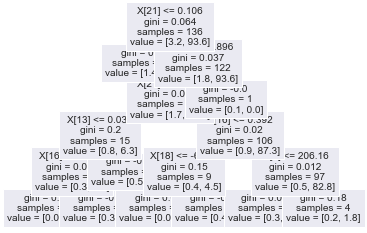

In [30]:
dt_fit = DecisionTreeClassifier(criterion="gini",max_depth=5,min_samples_split=2,
                                    min_samples_leaf=1,random_state=42,class_weight = {0:0.1, 1:0.9})
dt_fit.fit(X_train,y_train)
plot_tree(dt_fit, fontsize=10)
plt.show()

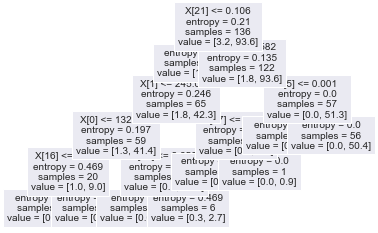

In [31]:
dt_fit = DecisionTreeClassifier(criterion="entropy",max_depth=5,min_samples_split=2,
                                    min_samples_leaf=1,random_state=42,class_weight = {0:0.1, 1:0.9})
dt_fit.fit(X_train,y_train)
plot_tree(dt_fit, fontsize=10)
plt.show()

In [34]:
y_train.unique()

array([1, 0], dtype=int64)

In [38]:
# Lime Explainer
explainer = lime_tabular.LimeTabularExplainer(X_train.values, mode='classification',
                                            feature_names=X_train.columns, 
                                            class_names=y_train.unique(),
                                             feature_selection='auto')

In [39]:
i = np.random.randint(0, X_train.shape[0])

# Using above model (Decision Tree - Criterion 'Entropy') in Lime explainer
exp = explainer.explain_instance(X_train.iloc[i], dt_fit.predict_proba)

print(f'Sample {i} - {X_train.iloc[2]}')
exp.show_in_notebook(show_table=True, show_all=False)

Sample 131 - MDVP:Fo(Hz)         183.520000
MDVP:Fhi(Hz)        216.814000
MDVP:Flo(Hz)        161.340000
MDVP:Jitter(%)        0.030168
MDVP:Jitter(Abs)      0.000080
MDVP:RAP              0.018032
MDVP:PPQ              0.016323
Jitter:DDP            0.054107
MDVP:Shimmer          0.060500
MDVP:Shimmer(dB)      0.618000
Shimmer:APQ3          0.028650
Shimmer:APQ5          0.041010
MDVP:APQ              0.083474
Shimmer:DDA           0.085950
NHR                   0.219660
HNR                  14.367000
RPDE                  0.478024
DFA                   0.768974
spread1              -4.276605
spread2               0.355736
D2                    3.142364
PPE                   0.336085
Name: phon_R01_S35_2, dtype: float64
